In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
import tsfresh
from datetime import timedelta

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from mlxtend.classifier import StackingCVClassifier
from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn.linear_model import LogisticRegression
from itertools import combinations
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.feature_selection import mutual_info_classif

from sklearn.feature_selection import SelectKBest

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

In [2]:
sensor_types = ['mic', 'acc']

In [3]:
def featSelect(X, y):
    return mutual_info_classif(X, y, random_state=101)

In [4]:
def trial_sample_extraction(path, disable_contact = False):
    sensors_dict = {}
    if disable_contact:
        sensors = ['acc', 'mic']
    else:
        sensors = ['contact', 'acc', 'mic']
    for sensor in sensors:
        full_path = path + '_' + sensor + '.csv'
        if not os.path.isfile(full_path):
            return False
        sample = pd.read_csv(full_path)
        sample['time_s'] = sample['time_s'].apply(lambda epoch: epoch * 1e9)
        sample['time_s'] = pd.to_datetime(sample['time_s'])
        sample = sample.drop(sample.columns[0], axis=1)
        sample.index = sample.time_s
        sample = sample.drop(['time_s'], axis=1)
        sensors_dict[sensor] = sample
    return sensors_dict

In [5]:
def calc_jerk(acc_df):
    date = pd.Series(acc_df.index)
    date.index = pd.to_datetime(date)
    time_d = (date - date.shift())
    time_d = time_d.apply(lambda x: (x.microseconds/1000))

    acc_df['jerk_x'] = acc_df['ax'].rolling(2).apply(lambda x: (x.iloc[1] - x.iloc[0]))
    acc_df['jerk_x'] = acc_df['jerk_x'].div(time_d)

    acc_df['jerk_y'] = acc_df['ay'].rolling(2).apply(lambda x: (x.iloc[1] - x.iloc[0]))
    acc_df['jerk_y'] = acc_df['jerk_y'].div(time_d)

    acc_df['jerk_z'] = acc_df['az'].rolling(2).apply(lambda x: (x.iloc[1] - x.iloc[0]))
    acc_df['jerk_z'] = acc_df['jerk_z'].div(time_d)
    acc_df.fillna(0, inplace=True)

    return acc_df

In [6]:
def calc_stats(df):
    stats_pd = pd.DataFrame()
    for sensor_type in sensor_types:
        for column in df[sensor_type].columns:
            stats_pd['mean_' + column] = [df[sensor_type][column].mean()]
            stats_pd['std_' + column] = [df[sensor_type][column].std()]
            stats_pd['min_' + column] = [df[sensor_type][column].min()]
            stats_pd['max_' + column] = [df[sensor_type][column].max()]
            stats_pd['var_' + column] = [df[sensor_type][column].var()]
            stats_pd['kurt_' + column] = [df[sensor_type][column].kurt()]
            stats_pd['skew_' + column] = [df[sensor_type][column].skew()]
            stats_pd['median_' + column] = [df[sensor_type][column].median()]
            stats_pd['abs_energy_' + column] = [tsfresh.feature_extraction.feature_calculators.abs_energy(df[sensor_type][column])]
            stats_pd['peaks_' + column] = [tsfresh.feature_extraction.feature_calculators.number_cwt_peaks(df[sensor_type][column], 2)]
            stats_pd['derv_central_' + column] = [tsfresh.feature_extraction.feature_calculators.mean_second_derivative_central(df[sensor_type][column])]
            stats_pd['mean_abs_change_' + column] = [tsfresh.feature_extraction.feature_calculators.mean_abs_change(df[sensor_type][column])]
            stats_pd['abs_sum_change_' + column] = [tsfresh.feature_extraction.feature_calculators.absolute_sum_of_changes(df[sensor_type][column])]
            stats_pd['fourier_entropy_' + column] = [tsfresh.feature_extraction.feature_calculators.fourier_entropy(df[sensor_type][column], 2)]
            rms = np.sqrt(np.mean(df[sensor_type][column]**2))
            stats_pd['root_mean_s_' + column] = [rms]
            stats_pd['shape_factor_' + column] = [rms / (df[sensor_type][column].apply(abs).mean())]
    stats_pd.reset_index(inplace=True, drop=True)
    return stats_pd

In [7]:
def encodeLabels(df, binary, binary_target=None):
    if binary:
        df['label'] = np.where(df['label'].str.contains(binary_target), 1, 0)
    else:
        encoder = LabelEncoder()
        df['label'] = encoder.fit_transform(df['label'])

In [8]:
def calcFeatureRelevance(df, binary):
    class_num = df['label'].nunique()
    X_f = df.drop('label', axis=1).astype(np.float64)
    y_f = df['label']
    df_relevant = tsfresh.feature_selection.relevance.calculate_relevance_table(X_f, y_f, 'classification', (not binary), class_num)
    smallest_f = np.sort(df_relevant[df_relevant['relevant'] == True].index)
    return smallest_f

In [9]:
def gridSearchBest(model, param_grid, cv, X, y):
    CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
    CV_rfc.fit(X, y)
    return CV_rfc.best_estimator_, CV_rfc.best_params_

In [10]:
def gridSearchSVMRF(sig_data, sig_data_attack_video, sig_data_attack_inperson, report_file, str_feat, sensor):
    X_a_v = sig_data_attack_video.drop('label', axis=1)
    y_a_v = sig_data_attack_video['label']

    X_a_p = sig_data_attack_inperson.drop('label', axis=1)
    y_a_p = sig_data_attack_inperson['label']

    X = sig_data.drop('label', axis=1)
    y = sig_data['label']

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_a_v = scaler.transform(X_a_v)
    X_a_p = scaler.transform(X_a_p)

    #RF

    model = RandomForestClassifier()

    param_grid = {
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6,7,8],
        'criterion' :['gini', 'entropy']
    }

    best_model, best_params = gridSearchBest(model, param_grid, cv, X, y)

    print('Random Forest - Grid Search - tested on attacks - ' + str_feat, file = report_file)
    print("Best params: " + str(best_params), file = report_file)
    best_model.fit(X, y)

    rf_predictions_v = best_model.predict(X_a_v)
    rf_predictions_p = best_model.predict(X_a_p)

    print(confusion_matrix(y_a_v, rf_predictions_v), file = report_file)
    print(classification_report(y_a_v, rf_predictions_v), file = report_file)
    print(accuracy_score(y_a_v, rf_predictions_v), file = report_file)
    rf_predictions_proba_v = best_model.predict_proba(X_a_v)
    fpr, tpr, thresholds = roc_curve(y_a_v, rf_predictions_proba_v[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure(figsize=(20,20))
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.title('ROC Curve for RF classifier - Video attacks')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend()
    fig.savefig('./reports_per_device/ROC_RF_Video_' + sensor + "_" + str_feat + ".pdf", format='pdf', dpi=600, bbox_inches = 'tight')

    print(confusion_matrix(y_a_p, rf_predictions_p), file = report_file)
    print(classification_report(y_a_p, rf_predictions_p), file = report_file)
    print(accuracy_score(y_a_p, rf_predictions_p), file = report_file)
    rf_predictions_proba_p = best_model.predict_proba(X_a_p)
    fpr, tpr, thresholds = roc_curve(y_a_p, rf_predictions_proba_p[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure(figsize=(20,20))
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.title('ROC Curve for RF classifier - In-person attacks')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend()
    fig.savefig('./reports_per_device/ROC_RF_In-Person_' + sensor + "_" + str_feat + ".pdf", format='pdf', dpi=600, bbox_inches = 'tight')

    #SVM

    model = SVC()
    param_grid = {
        'C': [0.1,1, 10, 100],
        'gamma': [1,0.1,0.01,0.001],
        'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
    }

    best_model, best_params = gridSearchBest(model, param_grid, cv, X, y)

    print('------------------', file = report_file)
    print('SVM - Grid Search - tested on attacks - ' + str_feat, file = report_file)
    print("Best params: " + str(best_params), file = report_file)

    best_model.fit(X, y)

    svm_predictions_v = best_model.predict(X_a_v)
    svm_predictions_p = best_model.predict(X_a_p)

    print(confusion_matrix(y_a_v, svm_predictions_v), file = report_file)
    print(classification_report(y_a_v, svm_predictions_v), file = report_file)
    print(accuracy_score(y_a_v, svm_predictions_v), file = report_file)

    clf = CalibratedClassifierCV(best_model) #to get probabilities from svm
    clf.fit(X, y)

    svm_predictions_proba_v = clf.predict_proba(X_a_v)
    fpr, tpr, thresholds = roc_curve(y_a_v, svm_predictions_proba_v[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure(figsize=(20,20))
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.title('ROC Curve for SVM classifier - Video attacks')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend()
    fig.savefig('./reports_per_device/ROC_SVM_Video_' + sensor + "_" + str_feat + ".pdf", format='pdf', dpi=600, bbox_inches = 'tight')

    print(confusion_matrix(y_a_p, svm_predictions_p), file = report_file)
    print(classification_report(y_a_p, svm_predictions_p), file = report_file)
    print(accuracy_score(y_a_p, svm_predictions_p), file = report_file)

    svm_predictions_proba_p = clf.predict_proba(X_a_p)
    fpr, tpr, thresholds = roc_curve(y_a_p, svm_predictions_proba_p[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure(figsize=(20,20))
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.title('ROC Curve for SVM classifier - In-person attacks')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend()
    fig.savefig('./reports_per_device/ROC_SVM_In-person_' + sensor + "_" + str_feat + ".pdf", format='pdf', dpi=600, bbox_inches = 'tight')

In [11]:
def calc_frrs(ens, _frrs_b_s, _tprs_b_s, _frrs_b_v, _tprs_b_v, _frrs_v_s, _tprs_v_s, _frrs_v_v, _tprs_v_v, _frrs_p_s, _tprs_p_s, _frrs_p_v, _tprs_p_v):

    print(ens)

    mean_frr_b_s = np.mean(_frrs_b_s, axis=0)
    mean_frr_b_s[-1] = 0.0
    mean_tpr_b_s = np.mean(_tprs_b_s, axis=0)
    mean_tpr_b_s[-1] = 1.0

    mean_frr_b_v = np.mean(_frrs_b_v, axis=0)
    mean_frr_b_v[-1] = 0.0
    mean_tpr_b_v = np.mean(_tprs_b_v, axis=0)
    mean_tpr_b_v[-1] = 1.0

    mean_frr_v_s = np.mean(_frrs_v_s, axis=0)
    mean_frr_v_s[-1] = 0.0
    mean_tpr_v_s = np.mean(_tprs_v_s, axis=0)
    mean_tpr_v_s[-1] = 1.0

    mean_frr_v_v = np.mean(_frrs_v_v, axis=0)
    mean_frr_v_v[-1] = 0.0
    mean_tpr_v_v = np.mean(_tprs_v_v, axis=0)
    mean_tpr_v_v[-1] = 1.0

    mean_frr_p_s = np.mean(_frrs_p_s, axis=0)
    mean_frr_p_s[-1] = 0.0
    mean_tpr_p_s = np.mean(_tprs_p_s, axis=0)
    mean_tpr_p_s[-1] = 1.0

    mean_frr_p_v = np.mean(_frrs_p_v, axis=0)
    mean_frr_p_v[-1] = 0.0
    mean_tpr_p_v = np.mean(_tprs_p_v, axis=0)
    mean_tpr_p_v[-1] = 1.0


    #Zero-effort

    print("Mean frr baseline (Stacking):")
    df_help = pd.DataFrame(columns=['fpr', 'frr'])
    df_help['fpr'] = mean_fpr_b_s
    df_help['frr'] = mean_frr_b_s
    FAR_at_01_b_s = df_help[round(df_help['fpr'],4) == 0.1000]['frr'].min()
    print("FAR 0.1: " + str(round(FAR_at_01_b_s,4)))
    FAR_at_001_b_s = df_help[round(df_help['fpr'],4) == 0.0100]['frr'].min()
    print("FAR 0.01: " + str(round(FAR_at_001_b_s,4)))
    FAR_at_0001 = df_help[round(df_help['fpr'],4) == 0.0010]['frr'].min()
    print("FAR 0.001: " + str(round(FAR_at_0001,4)))
    FAR_at_00001 = df_help[round(df_help['fpr'],4) == 0.0001]['frr'].min()
    print("FAR 0.0001: " + str(round(FAR_at_00001, 4)))


    print("Mean frr baseline (Voting):")
    df_help = pd.DataFrame(columns=['fpr', 'frr'])
    df_help['fpr'] = mean_fpr_b_v
    df_help['frr'] = mean_frr_b_v
    FAR_at_01_b_v = df_help[round(df_help['fpr'],4) == 0.1000]['frr'].min()
    print("FAR 0.1: " + str(round(FAR_at_01_b_v,4)))
    FAR_at_001_b_v = df_help[round(df_help['fpr'],4) == 0.0100]['frr'].min()
    print("FAR 0.01: " + str(round(FAR_at_001_b_v,4)))
    FAR_at_0001 = df_help[round(df_help['fpr'],4) == 0.0010]['frr'].min()
    print("FAR 0.001: " + str(round(FAR_at_0001,4)))
    FAR_at_00001 = df_help[round(df_help['fpr'],4) == 0.0001]['frr'].min()
    print("FAR 0.0001: " + str(round(FAR_at_00001, 4)))

    #Video

    print("Mean frr video (Stacking):")
    df_help = pd.DataFrame(columns=['fpr', 'frr'])
    df_help['fpr'] = mean_fpr_v_s
    df_help['frr'] = mean_frr_v_s
    FAR_at_01_v_s = df_help[round(df_help['fpr'],4) == 0.1000]['frr'].min()
    print("FAR 0.1: " + str(round(FAR_at_01_v_s, 4)))
    FAR_at_001_v_s = df_help[round(df_help['fpr'],4) == 0.0100]['frr'].min()
    print("FAR 0.01: " + str(round(FAR_at_001_v_s, 4)))
    FAR_at_0001 = df_help[round(df_help['fpr'],4) == 0.0010]['frr'].min()
    print("FAR 0.001: " + str(round(FAR_at_0001,4)))
    FAR_at_00001 = df_help[round(df_help['fpr'],4) == 0.0001]['frr'].min()
    print("FAR 0.0001: " + str(round(FAR_at_00001, 4)))

    print("Mean frr video (Voting):")
    df_help = pd.DataFrame(columns=['fpr', 'frr'])
    df_help['fpr'] = mean_fpr_v_v
    df_help['frr'] = mean_frr_v_v
    FAR_at_01_v_v = df_help[round(df_help['fpr'],4) == 0.1000]['frr'].min()
    print("FAR 0.1: " + str(round(FAR_at_01_v_v, 4)))
    FAR_at_001_v_v = df_help[round(df_help['fpr'],4) == 0.0100]['frr'].min()
    print("FAR 0.01: " + str(round(FAR_at_001_v_v, 4)))
    FAR_at_0001 = df_help[round(df_help['fpr'],4) == 0.0010]['frr'].min()
    print("FAR 0.001: " + str(round(FAR_at_0001,4)))
    FAR_at_00001 = df_help[round(df_help['fpr'],4) == 0.0001]['frr'].min()
    print("FAR 0.0001: " + str(round(FAR_at_00001, 4)))

    #In-person

    print("Mean frr in-person (Stacking):")
    df_help = pd.DataFrame(columns=['fpr', 'frr'])
    df_help['fpr'] = mean_fpr_p_s
    df_help['frr'] = mean_frr_p_s
    FAR_at_01_p_s = df_help[round(df_help['fpr'],4) == 0.1000]['frr'].min()
    print("FAR 0.1: " + str(round(FAR_at_01_p_s, 4)))
    FAR_at_001_p_s = df_help[round(df_help['fpr'],4) == 0.0100]['frr'].min()
    print("FAR 0.01: " + str(round(FAR_at_001_p_s, 4)))
    FAR_at_0001 = df_help[round(df_help['fpr'],4) == 0.0010]['frr'].min()
    print("FAR 0.001: " + str(round(FAR_at_0001,4)))
    FAR_at_00001 = df_help[round(df_help['fpr'],4) == 0.0001]['frr'].min()
    print("FAR 0.0001: " + str(round(FAR_at_00001, 4)))

    print("Mean frr in-person (Voting):")
    df_help = pd.DataFrame(columns=['fpr', 'frr'])
    df_help['fpr'] = mean_fpr_p_v
    df_help['frr'] = mean_frr_p_v
    FAR_at_01_p_v = df_help[round(df_help['fpr'],4) == 0.1000]['frr'].min()
    print("FAR 0.1: " + str(round(FAR_at_01_p_v, 4)))
    FAR_at_001_p_v = df_help[round(df_help['fpr'],4) == 0.0100]['frr'].min()
    print("FAR 0.01: " + str(round(FAR_at_001_p_v, 4)))
    FAR_at_0001 = df_help[round(df_help['fpr'],4) == 0.0010]['frr'].min()
    print("FAR 0.001: " + str(round(FAR_at_0001,4)))
    FAR_at_00001 = df_help[round(df_help['fpr'],4) == 0.0001]['frr'].min()
    print("FAR 0.0001: " + str(round(FAR_at_00001, 4)))

    return [FAR_at_01_b_s, FAR_at_001_b_s, FAR_at_01_b_v, FAR_at_001_b_v, FAR_at_01_v_s, FAR_at_001_v_s, FAR_at_01_v_v, FAR_at_001_v_v, FAR_at_01_p_s, FAR_at_001_p_s, FAR_at_01_p_v, FAR_at_001_p_v]

In [12]:
final_df = pd.DataFrame()
final_df_attacks = pd.DataFrame()
final_df_attacks_p = pd.DataFrame()
final_first_pass = True

set_sensors = ['O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8']

video_ppl = ['pE', 'pA', 'pC', 'pG', 'pI', 'pL']

for sensor in ['O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8']:

    directory_in_str = './data_dev/' + sensor + '/day2/data/'
    directory_in_str2 = './data_dev/' + sensor + '/day1/data/'

    binary = True
    s_f_num = 20
    set_names = set()
    set_paths = set()
    first_pass = True
    first_pass_attack = True
    per_device_df = pd.DataFrame()
    per_device_df_attack = pd.DataFrame()

    directory = os.fsencode(directory_in_str)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"):
            path = directory_in_str + filename
            path = path[:-4]
            path_elems = path.split("_")
            str_path = ""
            str_path = str_path.join("_".join(path_elems[:-1]))
            set_paths.add(str_path)

    directory = os.fsencode(directory_in_str2)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"):
            if True:
                path = directory_in_str2 + filename
                path = path[:-4]
                path_elems = path.split("_")
                str_path = ""
                str_path = str_path.join("_".join(path_elems[:-1]))
                set_paths.add(str_path)

    for path in sorted(set_paths):
        if True:

            #Extract the participant's name from the path
            path_elems_global = path.split("/")
            path_elems_local = path_elems_global[-1].split("_")
            if len(path_elems_local) < 5:
                continue
            part_name = path_elems_local[1][0] + path_elems_local[2]
            trial_stamp = path_elems_local[3] + "_" + path_elems_local[4]
            set_names.add(part_name)

            path_trial_part = "_".join(path_elems_local[1:])

            #Extract the participant's trial from the sensor folder
            sample1 = trial_sample_extraction(path)

            if len(sample1['contact']) < 2:
                continue

            time_start = sample1['contact']['status'][sample1['contact']['status'] == 'open'].index[0]
            time_stop = sample1['contact']['status'][sample1['contact']['status'] == 'close'].index[0]

            #Extract the event from the sample - open and close the doors
            for sensor_type in sensor_types:
                t1 = (sample1[sensor_type].index >= (time_start - timedelta(seconds=1)))
                t2 = (sample1[sensor_type].index <= (time_stop + timedelta(seconds=1)))
                mask = t1 & t2
                sample1[sensor_type] = sample1[sensor_type].loc[mask]

            #Calc jerk
            sample1['acc'] = calc_jerk(sample1['acc'])

            #Calc features
            sample1_stats = calc_stats(sample1)

            first = True
            #Extract paths from other devices based on the current trial and participant
            for sens in set_sensors:
                if sens not in [sensor]: #exclude the current device
                    if "contact" not in path_trial_part:
                        dir_ = './data_dev/' + sens + "/" + "/".join(path_elems_global[3:5]) + '/' + sens + "_" + path_trial_part
                        sample_exter = trial_sample_extraction(dir_, True)

                        if sample_exter == False:
                            continue

                        for sensor_type in sensor_types:
                            t1 = (sample_exter[sensor_type].index >= (time_start - timedelta(seconds=1)))
                            t2 = (sample_exter[sensor_type].index <= (time_stop + timedelta(seconds=1)))
                            mask = t1 & t2
                            sample_exter[sensor_type] = sample_exter[sensor_type].loc[mask]

                        sample_exter['acc'] = calc_jerk(sample_exter['acc'])
                        sample_exter_stats = calc_stats(sample_exter)
                        sample_exter_stats.columns = [col + '_' + sens for col in sample_exter_stats.columns]

                        if first:
                            first = False
                            per_colo_device_df = sample_exter_stats
                        else:
                            per_colo_device_df = pd.concat([per_colo_device_df, sample_exter_stats], axis=1)

            #both main and colocated
            #helper_df = pd.concat([sample1_stats, per_colo_device_df], axis=1) #features from all the devices from the user's trial n authenticating interaction x

            #only collocated
            helper_df = per_colo_device_df

            #only main one
            #helper_df = sample1_stats

            helper_df['label'] = part_name
            helper_df['trial_stamp'] = trial_stamp

            if 'attack' in path:
                if first_pass_attack:
                    first_pass_attack = False
                    per_device_df_attack = pd.DataFrame(columns=helper_df.columns)

                per_device_df_attack = per_device_df_attack.append(helper_df, ignore_index = True)
                continue

            if first_pass:
                first_pass = False
                per_device_df = pd.DataFrame(columns=helper_df.columns)

#             if any(substring in path for substring in substrings):
#                 per_device_df_attack = per_device_df_attack.append(sample1_stats, ignore_index = True)
#                 continue

            per_device_df = per_device_df.append(helper_df, ignore_index = True)


    per_device_df = per_device_df.dropna()
    per_device_df.columns = [col + '_' + sensor if col not in ['label', 'trial_stamp'] else col for col in per_device_df.columns]
    per_device_df_attack = per_device_df_attack.dropna()
    per_device_df_attack.columns = [col + '_' + sensor if col not in ['label', 'trial_stamp'] else col for col in per_device_df_attack.columns]

    if final_first_pass:
        final_df = per_device_df
        final_df_attacks = per_device_df_attack
        final_first_pass = False
        continue

    final_df = pd.merge(final_df, per_device_df, on=['label', 'trial_stamp'])
    final_df_attacks = pd.merge(final_df_attacks, per_device_df_attack, on=['label', 'trial_stamp'])

final_df = final_df.drop('trial_stamp', axis=1)
final_df_attacks = final_df_attacks.drop('trial_stamp', axis=1)

df_final_attack_video = final_df_attacks[final_df_attacks['label'].str.contains('|'.join(video_ppl))]
df_final_attack_inperson = final_df_attacks[~final_df_attacks['label'].str.contains('|'.join(video_ppl))]

final_df_copy = final_df.copy() #storing original labels for zero-effort
final_df_attacks_copy = final_df_attacks.copy() #storing original labels for attacks

encodeLabels(final_df, binary, 'pF')
encodeLabels(final_df_attacks, binary, 'pF')
encodeLabels(df_final_attack_video, binary, 'pF')
encodeLabels(df_final_attack_inperson, binary, 'pF')

feat_set = {}

t = 0.5


/var/folders/3d/w98_n4wj0x7cq61ljqncxjj80000gs/T/ipykernel_56462/3980674217.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = np.where(df['label'].str.contains(binary_target), 1, 0)


In [13]:
for sensor in ['O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8']:
    #Indexes of mutual inf
    device_cols = [col for col in final_df.columns if sensor in col[-2:]]
    X_c = final_df[device_cols]
    y_c = final_df['label']

    k = SelectKBest(featSelect, k=20).fit(X_c, y_c)
    X_new = X_c.iloc[:, k.get_support(indices=True)]
    feat_set[sensor] = X_new.columns

cv = StratifiedKFold(n_splits=10, random_state=101, shuffle=True)
sensors = ['O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8']

estims = [
('O1', make_pipeline(ColumnSelector(cols=feat_set["O1"]), RandomForestClassifier(criterion= 'entropy', max_depth = 7, max_features = 'auto', n_estimators = 200))),
('O2', make_pipeline(ColumnSelector(cols=feat_set["O2"]), StandardScaler(), SVC(C = 100, gamma = 0.01, kernel = 'rbf', probability=True))),
('O3', make_pipeline(ColumnSelector(cols=feat_set["O3"]), RandomForestClassifier(criterion= 'gini', max_depth = 5, max_features = 'sqrt', n_estimators = 200))),
('O4', make_pipeline(ColumnSelector(cols=feat_set["O4"]), RandomForestClassifier(criterion= 'gini', max_depth = 5, max_features = 'sqrt', n_estimators = 200))),
('O5', make_pipeline(ColumnSelector(cols=feat_set["O5"]), RandomForestClassifier(criterion= 'entropy', max_depth = 7, max_features = 'sqrt', n_estimators = 200))),
('O6', make_pipeline(ColumnSelector(cols=feat_set["O6"]), RandomForestClassifier(criterion= 'gini', max_depth = 4, max_features = 'auto', n_estimators = 500))),
('O7', make_pipeline(ColumnSelector(cols=feat_set["O7"]), RandomForestClassifier(criterion= 'entropy', max_depth = 8, max_features = 'log2', n_estimators = 500))),
('O8', make_pipeline(ColumnSelector(cols=feat_set["O8"]), StandardScaler(), SVC(C = 1, gamma = 1, kernel = 'linear', probability=True)))]

meta_class = LogisticRegression()

comb_2 = combinations(sensors, 2)
comb_3 = combinations(sensors, 3)
comb_4 = combinations(sensors, 4)
comb_5 = combinations(sensors, 5)
comb_6 = combinations(sensors, 6)
comb_7 = combinations(sensors, 7)
comb_8 = combinations(sensors, 8)

X = final_df.drop('label', axis=1)
y = final_df['label']

#combins = [list(comb_2), list(comb_3), list(comb_4), list(comb_5), list(comb_6), list(comb_7), list(comb_8)]
combins = [list(comb_2), list(comb_3), list(comb_4)]

#df_st_vo = pd.DataFrame(columns = ["FAR_Base_S", "FAR_Base_V", "FAR_All_S", "FAR_All_V", "FAR_Vid_S", "FAR_Vid_V", "FAR_Per_S", "FAR_Per_V"])
df_s = pd.DataFrame(columns = ["Zero_fpr", "Zero_tpr", "Video_fpr", "Video_tpr", "Person_fpr", "Person_tpr"])
df_v = pd.DataFrame(columns = ["Zero_fpr", "Zero_tpr", "Video_fpr", "Video_tpr", "Person_fpr", "Person_tpr"])

i = 1

ens_mean_frr_b_s = {}
ens_mean_tpr_b_s = {}

ens_mean_frr_b_v = {}
ens_mean_tpr_b_v = {}

ens_mean_frr_v_s = {}
ens_mean_tpr_v_s = {}

ens_mean_frr_v_v = {}
ens_mean_tpr_v_v = {}

ens_mean_frr_p_s = {}
ens_mean_tpr_p_s = {}

ens_mean_frr_p_v = {}
ens_mean_tpr_p_v = {}

#

fold_frr_b_s = {}
fold_tpr_b_s = {}

fold_frr_b_v = {}
fold_tpr_b_v = {}

fold_frr_v_s = {}
fold_tpr_v_s = {}

fold_frr_v_v = {}
fold_tpr_v_v = {}

fold_frr_p_s = {}
fold_tpr_p_s = {}

fold_frr_p_v = {}
fold_tpr_p_v = {}

df_sum_st = pd.DataFrame(columns = ["FAR_B", "FAR_V", "FAR_P"])
df_sum_vo = pd.DataFrame(columns = ["FAR_B", "FAR_V", "FAR_P"])
first_fold = True
ki = 0



for train_index, test_index in cv.split(X, y):
    tprs_b_s = []
    frrs_b_s = []
    aucs_b_s = []
    mean_fpr_b_s = np.linspace(0, 1, 10000)

    tprs_b_v = []
    frrs_b_v = []
    aucs_b_v = []
    mean_fpr_b_v = np.linspace(0, 1, 10000)

    tprs_v_s = []
    frrs_v_s = []
    aucs_v_s = []
    mean_fpr_v_s = np.linspace(0, 1, 10000)

    tprs_v_v = []
    frrs_v_v = []
    aucs_v_v = []
    mean_fpr_v_v = np.linspace(0, 1, 10000)

    tprs_p_s = []
    frrs_p_s = []
    aucs_p_s = []
    mean_fpr_p_s = np.linspace(0, 1, 10000)

    tprs_p_v = []
    frrs_p_v = []
    aucs_p_v = []
    mean_fpr_p_v = np.linspace(0, 1, 10000)


    df_bar_plot_stack = pd.DataFrame(columns = ["FAR_B", "FAR_V", "FAR_P"])
    df_bar_plot_vote = pd.DataFrame(columns = ["FAR_B", "FAR_V", "FAR_P"])

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    counterr = 0

    for comb_list in combins:
        df_st = pd.DataFrame(columns = ["FAR_B", "FAR_V", "FAR_P"])
        df_vo = pd.DataFrame(columns = ["FAR_B", "FAR_V", "FAR_P"])
        for comb in comb_list:
            active_estims = []
            labels = []
            for i in range(0, len(comb)):
                ind = sensors.index(comb[i])
                active_estims.append(estims[ind][1])
                labels.append(estims[ind][0])

            meta = StackingCVClassifier(classifiers = active_estims, meta_classifier = meta_class, cv=cv)
            meta2 = EnsembleVoteClassifier(clfs = active_estims, voting='soft')

            fit_model_stack = meta.fit(X_train, y_train)
            fit_model_voting = meta2.fit(X_train, y_train)

            #Baseline calcs
            pred_st = fit_model_stack.predict_proba(X_test)

            fpr_a_b_s, tpr_a_b_s, thresholds_a_b_s = roc_curve(y_test, pred_st[:, 1] , pos_label=1)
            frr_a_b_s = [1-i for i in tpr_a_b_s]
            roc_auc_a_b_s = auc(fpr_a_b_s, tpr_a_b_s)

            interp_tpr = np.interp(mean_fpr_b_s, fpr_a_b_s, tpr_a_b_s)
            interp_frr = np.interp(mean_fpr_b_s, fpr_a_b_s, frr_a_b_s)
            interp_tpr[0] = 0.0
            interp_frr[0] = 1
            frrs_b_s.append(interp_frr)
            tprs_b_s.append(interp_tpr)
            aucs_b_s.append(roc_auc_a_b_s)
            df_help = pd.DataFrame(columns=['fpr', 'tpr', 'tresh'])
            df_help['fpr'] = fpr_a_b_s
            df_help['tpr'] = tpr_a_b_s
            df_help['tresh'] = thresholds_a_b_s
            FAR_base_s = df_help[df_help['tpr'] == 1]['fpr'].min()

            fpr_a_b_v, tpr_a_b_v, thresholds_a_b_v = roc_curve(y_test, fit_model_voting.predict_proba(X_test)[:,1], pos_label=1)
            frr_a_b_v = [1-i for i in tpr_a_b_v]
            roc_auc_a_b_v = auc(fpr_a_b_v, tpr_a_b_v)

            interp_tpr = np.interp(mean_fpr_b_v, fpr_a_b_v, tpr_a_b_v)
            interp_frr = np.interp(mean_fpr_b_v, fpr_a_b_v, frr_a_b_v)
            interp_tpr[0] = 0.0
            interp_frr[0] = 1
            frrs_b_v.append(interp_frr)
            tprs_b_v.append(interp_tpr)
            aucs_b_v.append(roc_auc_a_b_v)
            df_help = pd.DataFrame(columns=['fpr', 'tpr', 'tresh'])
            df_help['fpr'] = fpr_a_b_v
            df_help['tpr'] = tpr_a_b_v
            df_help['tresh'] = thresholds_a_b_v
            FAR_base_v = df_help[df_help['tpr'] == 1]['fpr'].min()

            complete_df = pd.concat([X_test, y_test], axis = 1)
            victim_test = complete_df[complete_df['label'] == 1]

            con_tr_av = pd.concat([df_final_attack_video, victim_test], axis=0)
            X_a_v = con_tr_av.drop('label', axis=1)
            y_a_v = con_tr_av['label']

            con_tr_ap = pd.concat([df_final_attack_inperson, victim_test], axis=0)
            X_a_p = con_tr_ap.drop('label', axis=1)
            y_a_p = con_tr_ap['label']

            fpr_a_v_s, tpr_a_v_s, thresholds_a_v_s = roc_curve(y_a_v, fit_model_stack.predict_proba(X_a_v)[:, 1], pos_label=1)
            frr_a_v_s = [1-i for i in tpr_a_v_s]
            roc_auc_a_v_s = auc(fpr_a_v_s, tpr_a_v_s)

            interp_tpr = np.interp(mean_fpr_v_s, fpr_a_v_s, tpr_a_v_s)
            interp_frr = np.interp(mean_fpr_v_s, fpr_a_v_s, frr_a_v_s)
            interp_tpr[0] = 0.0
            interp_frr[0] = 1
            tprs_v_s.append(interp_tpr)
            frrs_v_s.append(interp_frr)
            aucs_v_s.append(roc_auc_a_v_s)
            df_help = pd.DataFrame(columns=['fpr', 'tpr', 'tresh'])
            df_help['fpr'] = fpr_a_v_s
            df_help['tpr'] = tpr_a_v_s
            df_help['tresh'] = thresholds_a_v_s
            FAR_av_s = df_help[df_help['tpr'] == 1]['fpr'].min()

            fpr_a_v_v, tpr_a_v_v, thresholds_a_v_v = roc_curve(y_a_v, fit_model_voting.predict_proba(X_a_v)[:,1], pos_label=1)
            frr_a_v_v = [1-i for i in tpr_a_v_v]
            roc_auc_a_v_v = auc(fpr_a_v_v, tpr_a_v_v)

            interp_tpr = np.interp(mean_fpr_v_v, fpr_a_v_v, tpr_a_v_v)
            interp_frr = np.interp(mean_fpr_v_v, fpr_a_v_v, frr_a_v_v)
            interp_tpr[0] = 0.0
            interp_frr[0] = 1
            tprs_v_v.append(interp_tpr)
            frrs_v_v.append(interp_frr)
            aucs_v_v.append(roc_auc_a_v_v)
            df_help = pd.DataFrame(columns=['fpr', 'tpr', 'tresh'])
            df_help['fpr'] = fpr_a_v_v
            df_help['tpr'] = tpr_a_v_v
            df_help['tresh'] = thresholds_a_v_v
            FAR_av_v = df_help[df_help['tpr'] == 1]['fpr'].min()

            fpr_a_p_s, tpr_a_p_s, thresholds_a_p_s = roc_curve(y_a_p, fit_model_stack.predict_proba(X_a_p)[:,1], pos_label=1)
            frr_a_p_s = [1-i for i in tpr_a_p_s]
            roc_auc_a_p_s = auc(fpr_a_p_s, tpr_a_p_s)

            interp_tpr = np.interp(mean_fpr_p_s, fpr_a_p_s, tpr_a_p_s)
            interp_frr = np.interp(mean_fpr_p_s, fpr_a_p_s, frr_a_p_s)
            interp_tpr[0] = 0.0
            interp_frr[0] = 1
            tprs_p_s.append(interp_tpr)
            frrs_p_s.append(interp_frr)
            aucs_p_s.append(roc_auc_a_p_s)
            df_help = pd.DataFrame(columns=['fpr', 'tpr', 'tresh'])
            df_help['fpr'] = fpr_a_p_s
            df_help['tpr'] = tpr_a_p_s
            df_help['tresh'] = thresholds_a_p_s
            FAR_ap_s = df_help[df_help['tpr'] == 1]['fpr'].min()

            fpr_a_p_v, tpr_a_p_v, thresholds_a_p_v = roc_curve(y_a_p, fit_model_voting.predict_proba(X_a_p)[:,1], pos_label=1)
            frr_a_p_v = [1-i for i in tpr_a_p_v]
            roc_auc_a_p_v = auc(fpr_a_p_v, tpr_a_p_v)

            interp_tpr = np.interp(mean_fpr_p_v, fpr_a_p_v, tpr_a_p_v)
            interp_frr = np.interp(mean_fpr_p_v, fpr_a_p_v, frr_a_p_v)
            interp_tpr[0] = 0.0
            interp_frr[0] = 1
            tprs_p_v.append(interp_tpr)
            frrs_p_v.append(interp_frr)
            aucs_p_v.append(roc_auc_a_p_v)
            df_help = pd.DataFrame(columns=['fpr', 'tpr', 'tresh'])
            df_help['fpr'] = fpr_a_p_v
            df_help['tpr'] = tpr_a_p_v
            df_help['tresh'] = thresholds_a_p_v
            FAR_ap_v = df_help[df_help['tpr'] == 1]['fpr'].min()

            df_st.loc["_".join(labels)] = [FAR_base_s, FAR_av_s, FAR_ap_s]
            df_vo.loc["_".join(labels)] = [FAR_base_v,  FAR_av_v,  FAR_ap_v]

        if len(comb) == 2:
            ens = "Two devices"
        if len(comb) == 3:
            ens = "Three devices"
        if len(comb) == 4:
            ens = "Four devices"
        if len(comb) == 5:
            ens = "Five devices"
        if len(comb) == 6:
            ens = "Six devices"
        if len(comb) == 7:
            ens = "Seven devices"
        if len(comb) == 8:
            ens = "Eight devices"

        df_bar_plot_stack.loc[ens] = [df_st['FAR_B'].mean(), df_st['FAR_V'].mean(), df_st['FAR_P'].mean()]
        df_bar_plot_vote.loc[ens] = [df_vo['FAR_B'].mean(), df_vo['FAR_V'].mean(), df_vo['FAR_P'].mean()]

        ens_mean_frr_b_s[ens] = np.mean(frrs_b_s, axis=0)
        ens_mean_tpr_b_s[ens] = np.mean(tprs_b_s, axis=0)

        ens_mean_frr_b_v[ens] = np.mean(frrs_b_v, axis=0)
        ens_mean_tpr_b_v[ens] = np.mean(tprs_b_v, axis=0)

        ens_mean_frr_v_s[ens] = np.mean(frrs_v_s, axis=0)
        ens_mean_tpr_v_s[ens] = np.mean(tprs_v_s, axis=0)

        ens_mean_frr_v_v[ens] = np.mean(frrs_v_v, axis=0)
        ens_mean_tpr_v_v[ens] = np.mean(tprs_v_v, axis=0)

        ens_mean_frr_p_s[ens] = np.mean(frrs_p_s, axis=0)
        ens_mean_tpr_p_s[ens] = np.mean(tprs_p_s, axis=0)

        ens_mean_frr_p_v[ens] = np.mean(frrs_p_v, axis=0)
        ens_mean_tpr_p_v[ens] = np.mean(tprs_p_v, axis=0)


    ki = ki + 1
    #print("Stacking")
    #print(df_bar_plot_stack)
    #print("Voting")
    #print(df_bar_plot_vote)
    if first_fold:
        df_sum_st = df_bar_plot_stack.copy()
        df_sum_vo = df_bar_plot_vote.copy()
        first_fold = False
        for i in ["Two devices", "Three devices", "Four devices"]:
            fold_frr_b_s[i] = [ens_mean_frr_b_s[i]]
            fold_tpr_b_s[i] = [ens_mean_tpr_b_s[i]]

            fold_frr_b_v[i] = [ens_mean_frr_b_v[i]]
            fold_tpr_b_v[i] = [ens_mean_tpr_b_v[i]]

            fold_frr_v_s[i] = [ens_mean_frr_v_s[i]]
            fold_tpr_v_s[i] = [ens_mean_tpr_v_s[i]]

            fold_frr_v_v[i] = [ens_mean_frr_v_v[i]]
            fold_tpr_v_v[i] = [ens_mean_tpr_v_v[i]]

            fold_frr_p_s[i] = [ens_mean_frr_p_s[i]]
            fold_tpr_p_s[i] = [ens_mean_tpr_p_s[i]]

            fold_frr_p_v[i] = [ens_mean_frr_p_v[i]]
            fold_tpr_p_v[i] = [ens_mean_frr_p_v[i]]
    else:
        df_sum_st = df_sum_st.add(df_bar_plot_stack)
        #print("After Sum Stacking")
        #print(df_sum_st)
        df_sum_vo = df_sum_vo.add(df_bar_plot_vote)
        #print("After Sum Voting")
        #print(df_sum_vo)

        #,
        for i in ["Two devices", "Three devices", "Four devices"]:
            fold_frr_b_s[i].append(ens_mean_frr_b_s[i])
            fold_tpr_b_s[i].append(ens_mean_tpr_b_s[i])

            fold_frr_b_v[i].append(ens_mean_frr_b_v[i])
            fold_tpr_b_v[i].append(ens_mean_tpr_b_v[i])

            fold_frr_v_s[i].append(ens_mean_frr_v_s[i])
            fold_tpr_v_s[i].append(ens_mean_tpr_v_s[i])

            fold_frr_v_v[i].append(ens_mean_frr_v_v[i])
            fold_tpr_v_v[i].append(ens_mean_tpr_v_v[i])

            fold_frr_p_s[i].append(ens_mean_frr_p_s[i])
            fold_tpr_p_s[i].append(ens_mean_tpr_p_s[i])

            fold_frr_p_v[i].append(ens_mean_frr_p_v[i])
            fold_tpr_p_v[i].append(ens_mean_frr_p_v[i])

df_frrs_ens = pd.DataFrame(columns = ["Zero-effort (Stacking, FAR = 0.1)", "Zero-effort (Stacking, FAR = 0.01)",
                       "Zero-effort (Voting, FAR = 0.1)", "Zero-effort (Voting, FAR = 0.01)",
                        "Video (Stacking, FAR = 0.1)", "Video (Stacking, FAR = 0.01)",
                       "Video (Voting, FAR = 0.1)", "Video (Voting, FAR = 0.01)",
                        "In-Person (Stacking, FAR = 0.1)", "In-Person (Stacking, FAR = 0.01)",
                       "In-Person (Voting, FAR = 0.1)", "In-Person (Voting, FAR = 0.01)"])

for i in ["Two devices", "Three devices", "Four devices"]:
    df_frrs_ens.loc[i] = calc_frrs(i, fold_frr_b_s[i], fold_tpr_b_s[i], fold_frr_b_v[i], fold_tpr_b_v[i],
                                   fold_frr_v_s[i], fold_tpr_v_s[i], fold_frr_v_v[i], fold_tpr_v_v[i],
                                   fold_frr_p_s[i], fold_tpr_p_s[i], fold_frr_p_v[i], fold_tpr_p_v[i])

print("------ DF all -----")
print(df_frrs_ens)
print("------ DF all -----")

Two devices
Mean frr baseline (Stacking):
FAR 0.1: 0.0161
FAR 0.01: 0.0177
FAR 0.001: 0.0178
FAR 0.0001: 0.0179
Mean frr baseline (Voting):
FAR 0.1: 0.0018
FAR 0.01: 0.0018
FAR 0.001: 0.0018
FAR 0.0001: 0.0018
Mean frr video (Stacking):
FAR 0.1: 0.1422
FAR 0.01: 0.3269
FAR 0.001: 0.3831
FAR 0.0001: 0.3887
Mean frr video (Voting):
FAR 0.1: 0.0589
FAR 0.01: 0.0679
FAR 0.001: 0.0679
FAR 0.0001: 0.0679
Mean frr in-person (Stacking):
FAR 0.1: 0.0284
FAR 0.01: 0.086
FAR 0.001: 0.1082
FAR 0.0001: 0.1105
Mean frr in-person (Voting):
FAR 0.1: 0.0286
FAR 0.01: 0.0375
FAR 0.001: 0.0375
FAR 0.0001: 0.0375
Three devices
Mean frr baseline (Stacking):
FAR 0.1: 0.008
FAR 0.01: 0.0088
FAR 0.001: 0.0089
FAR 0.0001: 0.0089
Mean frr baseline (Voting):
FAR 0.1: 0.0006
FAR 0.01: 0.0006
FAR 0.001: 0.0006
FAR 0.0001: 0.0006
Mean frr video (Stacking):
FAR 0.1: 0.0959
FAR 0.01: 0.2294
FAR 0.001: 0.2736
FAR 0.0001: 0.2781
Mean frr video (Voting):
FAR 0.1: 0.0429
FAR 0.01: 0.0494
FAR 0.001: 0.0494
FAR 0.0001: 0.0

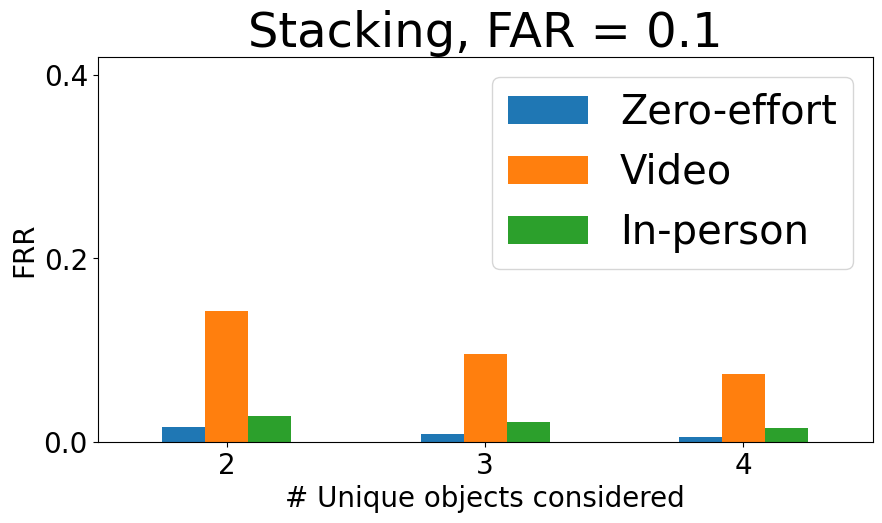

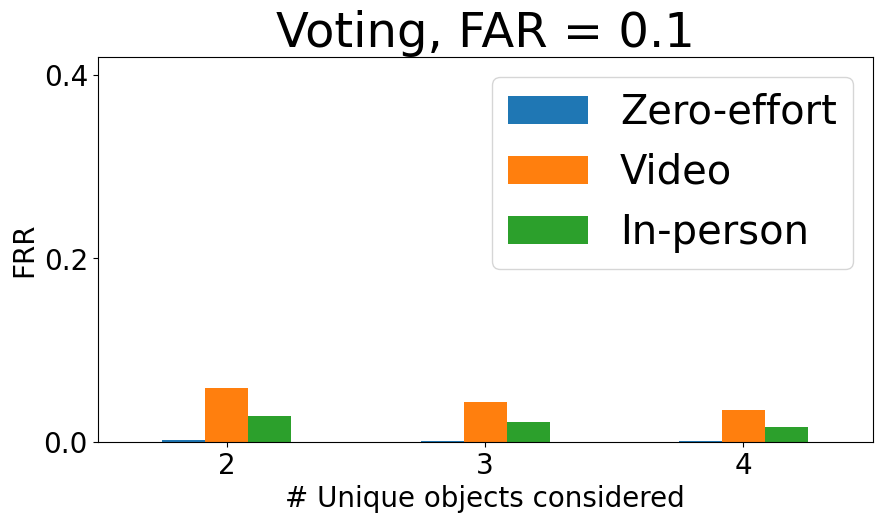

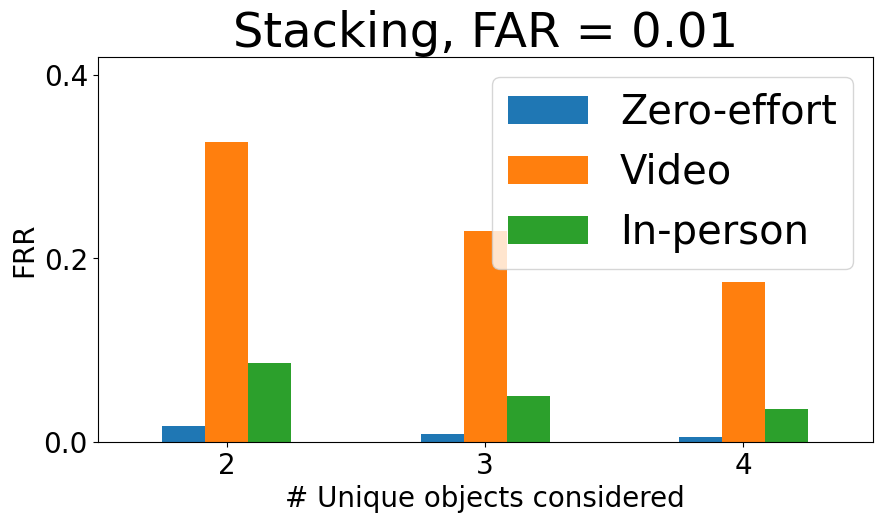

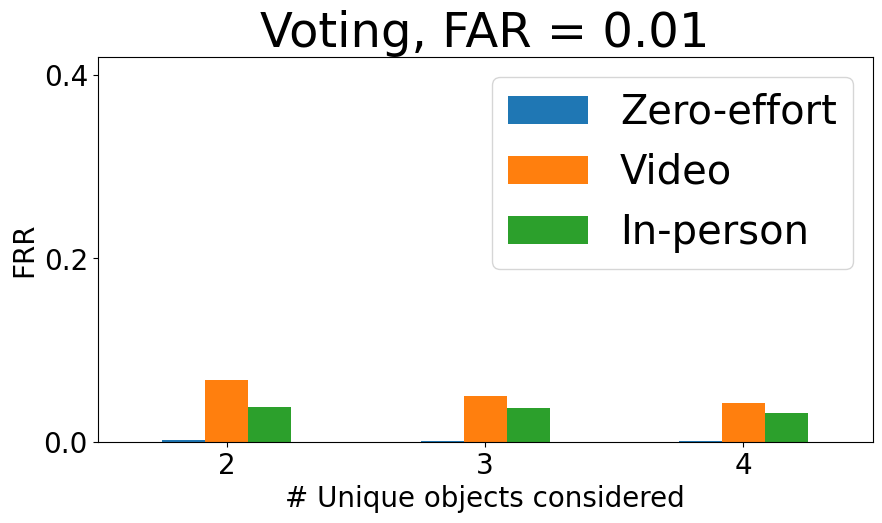

In [14]:
plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rc('xtick',labelsize=30)
plt.rc('ytick',labelsize=30)

fig, ax = plt.subplots()
df_st_01 = df_frrs_ens.loc[:, df_frrs_ens.columns.str.contains('Stacking, FAR = 0.1')]
pl = df_st_01.plot(kind="bar", figsize=(10,5), title="Stacking, FAR = 0.1", ax=ax, rot=0, fontsize=15)
pl.set_xticklabels(("2", "3", "4"))  #, "5", "6", "7", "8"))
plt.legend(prop={'size':15})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel('# Unique objects considered', fontsize=20)
plt.ylabel('FRR', fontsize=20)
plt.ylim([0, 0.42])
ax.legend(["Zero-effort", "Video", "In-person"], fontsize = 'x-large')
fig.savefig('./Figure7a' + ".pdf", format='pdf', dpi=600, bbox_inches = 'tight')

fig, ax = plt.subplots()
df_vo_01 = df_frrs_ens.loc[:, df_frrs_ens.columns.str.contains('Voting, FAR = 0.1')]
pl = df_vo_01.plot(kind="bar", figsize=(10,5), title="Voting, FAR = 0.1", ax=ax, rot=0, fontsize=15)
pl.set_xticklabels(("2", "3", "4"))  #, "5", "6", "7", "8"))
plt.legend(prop={'size':15})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel('# Unique objects considered', fontsize=20)
plt.ylabel('FRR', fontsize=20)
plt.ylim([0, 0.42])
ax.legend(["Zero-effort", "Video", "In-person"], fontsize = 'x-large')
fig.savefig('./Figure7b' + ".pdf", format='pdf', dpi=600, bbox_inches = 'tight')


fig, ax = plt.subplots()
df_st_001 = df_frrs_ens.loc[:, df_frrs_ens.columns.str.contains('Stacking, FAR = 0.01')]
pl = df_st_001.plot(kind="bar", figsize=(10,5), title="Stacking, FAR = 0.01", ax=ax, rot=0, fontsize=15)
pl.set_xticklabels(("2", "3", "4"))  #, "5", "6", "7", "8"))
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(prop={'size':15})
plt.xlabel('# Unique objects considered', fontsize=20)
plt.ylabel('FRR', fontsize=20)
plt.ylim([0, 0.42])
ax.legend(["Zero-effort", "Video", "In-person"], fontsize = 'x-large')
fig.savefig('./Figure7c' + ".pdf", format='pdf', dpi=600, bbox_inches = 'tight')

fig, ax = plt.subplots()
df_vo_001 = df_frrs_ens.loc[:, df_frrs_ens.columns.str.contains('Voting, FAR = 0.01')]
pl = df_vo_001.plot(kind="bar", figsize=(10,5), title="Voting, FAR = 0.01", ax=ax, rot=0, fontsize=15)
pl.set_xticklabels(("2", "3", "4"))  #, "5", "6", "7", "8"))
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(prop={'size':15})
plt.xlabel('# Unique objects considered', fontsize=20)
plt.ylabel('FRR', fontsize=20)
plt.ylim([0, 0.42])
ax.legend(["Zero-effort", "Video", "In-person"], fontsize = 'x-large')
fig.savefig('./Figure7d' + ".pdf", format='pdf', dpi=600, bbox_inches = 'tight')